# Studio di Predizione dei Livelli di Radiazioni Solari
***Programmazione di Applicazioni Data Intensive***

Nome Studente: Osimani Lorenzo

Matricola: 0000794229

Email: lorenzo.osimani@studio.unibo.it

In [0]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as datetime
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

Il database scelto come oggetto di studio è reperebile su Kaggle all'indirizzo *https://www.kaggle.com/dronio/SolarEnergy*.
In esso sono raccolte delle rilevazioni effettuate dalla stazione meteorologica HI-SEAS nel corso di 4 mesi (da Settembre 2016 a Dicembre 2016).

L'obiettivo dello studio è cercare di prevedere l'andamento del livello delle radiazioni solari: un'applicazione pratica di questo studio potrebbe essere per determinare se sia utile usare batterie solari in un futuro periodo.
Inizio dunque caricando il database dal file csv ed analizzando le varie colonne.

# Analisi Preliminare

Analizzo i dati evidenziando le tipologie, la quantità di memoria che occupano ed altre informazioni.
Per le variabili numeriche utilizzo il metodo .describe(), mentre per quelle non numeriche calcolo quanti sono i valori unici.

In [8]:
data = pd.read_csv("SolarPrediction.csv", parse_dates=["Data"])
data.head(3)

UNIXTime       Data      Time  ...  Speed  TimeSunRise  TimeSunSet
0  1475229326 2016-09-29  23:55:26  ...   5.62     06:13:00    18:13:00
1  1475229023 2016-09-29  23:50:23  ...   3.37     06:13:00    18:13:00
2  1475228726 2016-09-29  23:45:26  ...   3.37     06:13:00    18:13:00

[3 rows x 11 columns]

In [9]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null datetime64[ns]
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 8.1 MB


Vi sono 11 colonne diverse:

- <b>UNIXTime</b> : rappresenta il momento della rilevazione in Tempo Unix, cioè come offset in secondi rispetto alla mezzanotte (UTC) del 1º gennaio 1970
- <b>Data</b> : il giorno della rilevazione, oggetto DateTime
- <b>Time</b> : l'ora della rilevazione, non numerico
- <b>Radiation</b> : il valore da predire, il livello di radiazioni in Watts per meter^2
- <b>Temperature</b> : la temperatura in gradi Fahrenheit
- <b>Pressure</b> : la pressione barometrica in Hg
- <b>Humidity</b> : l'umidità in percentuale
- <b>WindDirection(Degrees)</b> : la direzione del vento in gradi
- <b>Speed</b> : la velocità del vento in miglia orarie
- <b>TimeSunRise</b> : l'ora in cui il sole è sorto il giorno della rilevazione, non numerico
- <b>TimeSunSet</b> : l'ora in cui il sole è tramontato il giorno della rilevazione, non numerico

La variabile da predire è di tipo continua.

In [10]:
data.describe()

UNIXTime     Radiation  ...  WindDirection(Degrees)         Speed
count  3.268600e+04  32686.000000  ...            32686.000000  32686.000000
mean   1.478047e+09    207.124697  ...              143.489821      6.243869
std    3.005037e+06    315.916387  ...               83.167500      3.490474
min    1.472724e+09      1.110000  ...                0.090000      0.000000
25%    1.475546e+09      1.230000  ...               82.227500      3.370000
50%    1.478026e+09      2.660000  ...              147.700000      5.620000
75%    1.480480e+09    354.235000  ...              179.310000      7.870000
max    1.483265e+09   1601.260000  ...              359.950000     40.500000

[8 rows x 7 columns]

In [11]:
print('Non numeric values count')
for col in data[['Data', 'Time', 'TimeSunRise', 'TimeSunSet']].columns: 
    print('Unique values in', col ,':\t', data[col].nunique())
    if(data[col].unique().size < 20):
        print('\t', data[col].unique())

Non numeric values count
Unique values in Data :	 118
Unique values in Time :	 8299
Unique values in TimeSunRise :	 51
Unique values in TimeSunSet :	 56


Le rilevazioni sono state effettuate lungo un periodo di 118 giorni.

Per ridurre lo spazio in memoria converto tutti in tempi in oggetti timedelta, il tempo unix in un oggetto DateTime e uso quest'ultimo come index del dataframe.

In [12]:
data_rev = data.assign(TimeSunRise=data['TimeSunRise'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').time()), 
                   TimeSunSet=data['TimeSunSet'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').time()), 
                   Time=data['Time'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').time()),
                   DateTime = pd.to_datetime(data['UNIXTime'], unit='s'))

data_rev.set_index('DateTime', inplace=True)
data_rev.head(3)

UNIXTime       Data  ... TimeSunRise  TimeSunSet
DateTime                                    ...                        
2016-09-30 09:55:26  1475229326 2016-09-29  ...    06:13:00    18:13:00
2016-09-30 09:50:23  1475229023 2016-09-29  ...    06:13:00    18:13:00
2016-09-30 09:45:26  1475228726 2016-09-29  ...    06:13:00    18:13:00

[3 rows x 11 columns]

In [13]:
data_rev.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32686 entries, 2016-09-30 09:55:26 to 2016-12-01 10:00:02
Data columns (total 11 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null datetime64[ns]
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 6.7 MB


I tempo delle segnalazioni ha un diverso fuso orario rispetto a quello ricavato dall'UNIXTime; deduco che il fuso orario sia diverso.
Sapendo che i dati sono stati raccolti dalla stazione meteorologica HI-SEAS, situata alle Hawaii, supponiamo che il fuso orario sia di quelle zone. 
Includo dunque la libreria pytz per ricavare il formato giusto.

In [14]:
import pytz
from pytz import timezone

df = data_rev.copy()
df.index = data_rev.index.tz_localize(pytz.utc).tz_convert(timezone('US/Hawaii'))
df.sort_index(inplace=True)
df.head(3)

UNIXTime       Data  ... TimeSunRise  TimeSunSet
DateTime                                          ...                        
2016-09-01 00:00:08-10:00  1472724008 2016-09-01  ...    06:07:00    18:38:00
2016-09-01 00:05:10-10:00  1472724310 2016-09-01  ...    06:07:00    18:38:00
2016-09-01 00:20:06-10:00  1472725206 2016-09-01  ...    06:07:00    18:38:00

[3 rows x 11 columns]

Cancello le colonne UNIXTime, Data e Time poichè ormai contenute nell'indice e dunque inutili.

In [0]:
del df['UNIXTime']
del df['Data']
del df['Time']

Analizzo ora i dati in un grafico a dispersione per evidenziare possibili patterns. Creo una funzione per la creazione di grafici.

In [0]:
def scatterplot(datax, datay, title, xtitle, ytitle):
    plt.figure(figsize = (18,10))
    plt.scatter(datax, datay)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.title(title)
    plt.show()

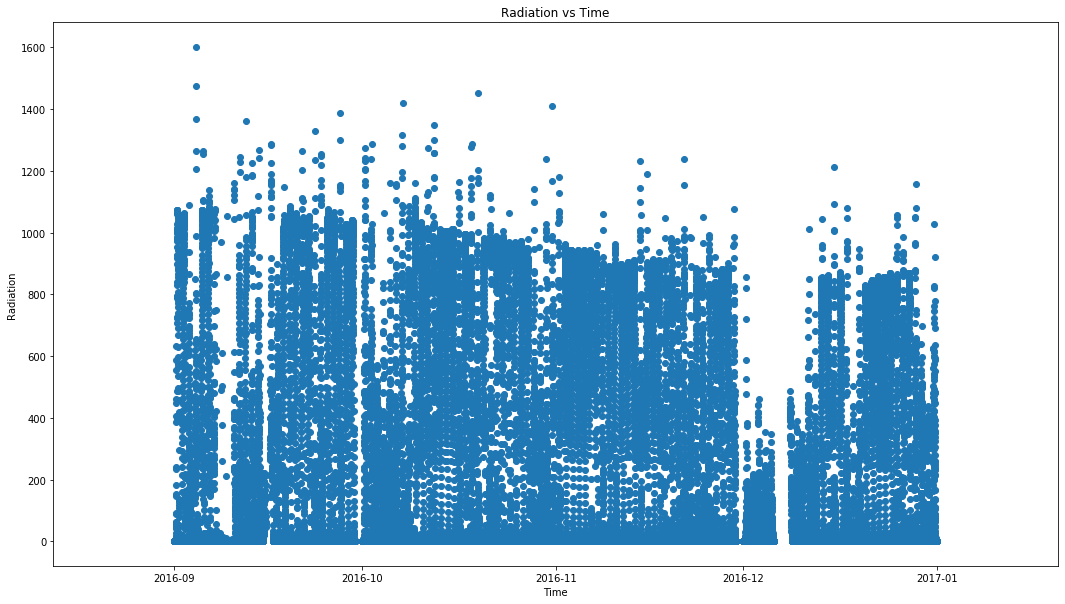

In [19]:
scatterplot(df.index, df["Radiation"], "Radiation vs Time", "Time", "Radiation")

Il grafico evidenzia dei picchi periodici, ed una diminuzione notevole di rilevazioni nel mese di Dicembre e in due punti del mese di Settembre.
Creo una funzione in grado di mostrare i dati di una variabile in un determinato intervallo di tempo per osservare più nel dettaglio l'andamento.

In [0]:
def interval_data_plot(ax, data, column, start_date, end_date):
    plt.rcParams['figure.figsize'] = 15, 10
    interval = data[(data.index > start_date) & (data.index < end_date)]
    dates = interval.index
    col = interval[column]
    
    start_date = start_date.strftime('%m/%d/%Y')
    end_date = end_date.strftime('%m/%d/%Y')
    
    ax.plot(dates, col)
    
    ax.set_title('{column} from {start_date} to {end_date}'.format(column=column, start_date=start_date, end_date=end_date))
    ax.set_ylabel('{column}'.format(column=column))
    ax.set_xlabel('Date')
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    
    return ax

Analizzo la prima settimana del dataframe nel dettaglio.

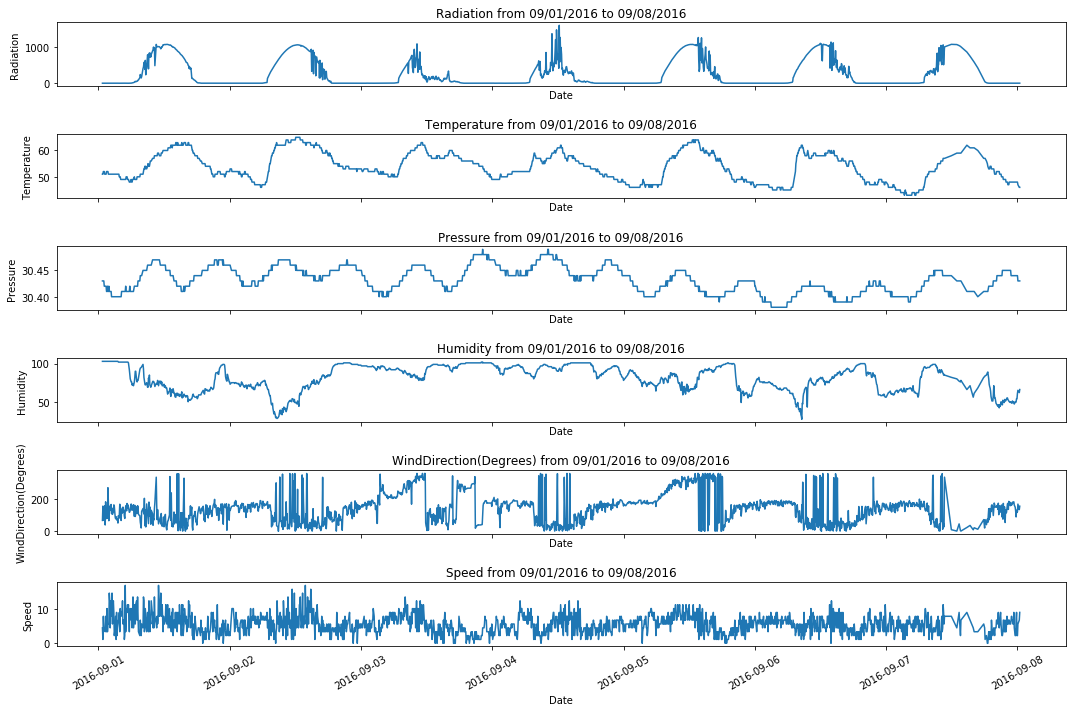

In [22]:
cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']
fig, axes = plt.subplots(len(cols), sharex=True)
for i, ax in enumerate(axes):
    ax = interval_data_plot(
        ax,
        df,
        cols[i],
        datetime.datetime(2016,9, 1).replace(tzinfo=timezone('US/Hawaii')),
        datetime.datetime(2016,9, 8).replace(tzinfo=timezone('US/Hawaii'))
    )
    
fig.tight_layout()

È evidente che vi è una periodicità nei pattern, con dei picchi che sono raggiunti quando il sole è più alto nella giornata.
La temperatura ha lo stesso periodo della quantità di radiazioni, mentre la pressione ha un periodo di ciclo diverso.
L'umidità, la velocità e la direzione del vento sembrano essere solo rumore: probabilmente saranno meno influenti nel calcolo della variabile dipendente.
Calcoliamo la correlazione di Pearson per evidenziare quale proporzionalità ci sia fra le variabili, e mostriamola in un grafico.

Text(0.5, 1, 'Pearson Correlation')

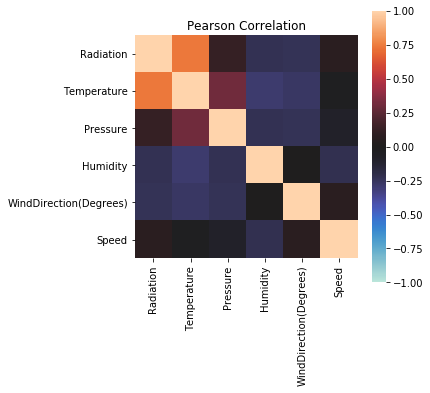

In [23]:
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']].corr(), center = 0,  vmin = -1, vmax = 1 , square=True)
plt.title('Pearson Correlation')

Come avevamo ipotizzato, la variabile più correlata alla radiazione con proporzionalità diretta è la temperatura, seguita dalla pressione.
Gli altri dati rimangono poco influenti.

Analizziamo ora i periodi dove avevamo precedentemente notato una mancanza di dati.

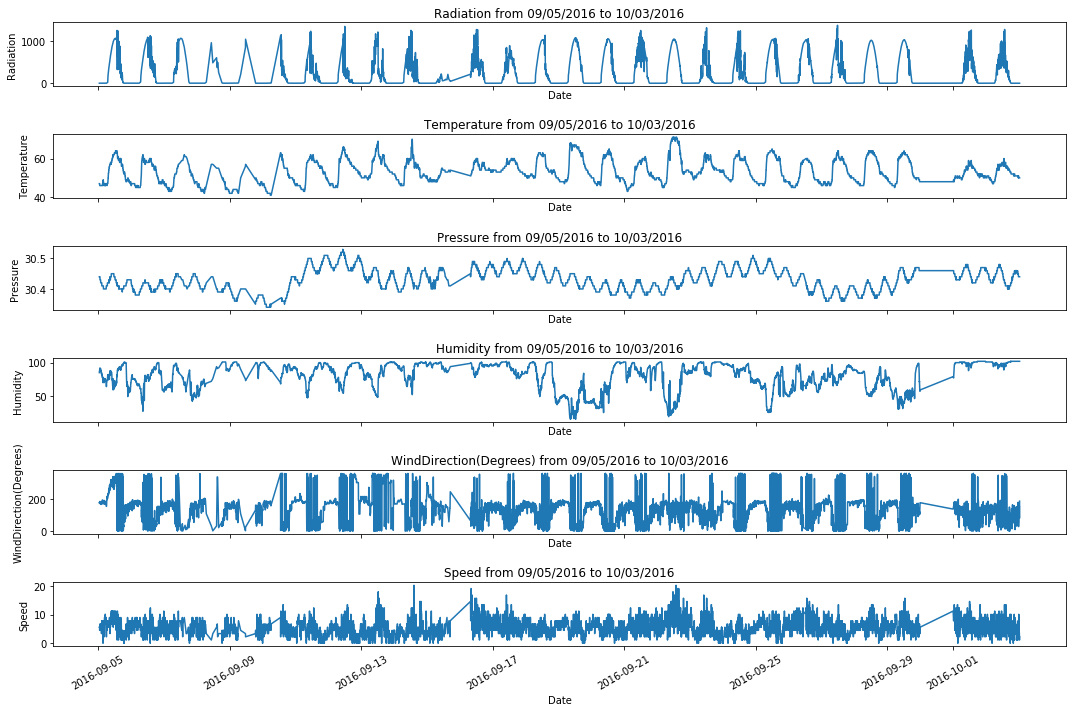

In [25]:
fig, axes = plt.subplots(len(cols), sharex=True)
for i, ax in enumerate(axes):
    ax = interval_data_plot(
        ax,
        df,
        cols[i],
        datetime.datetime(2016,9, 5).replace(tzinfo=timezone('US/Hawaii')),
        datetime.datetime(2016,10, 3).replace(tzinfo=timezone('US/Hawaii'))
    )
    
fig.tight_layout()

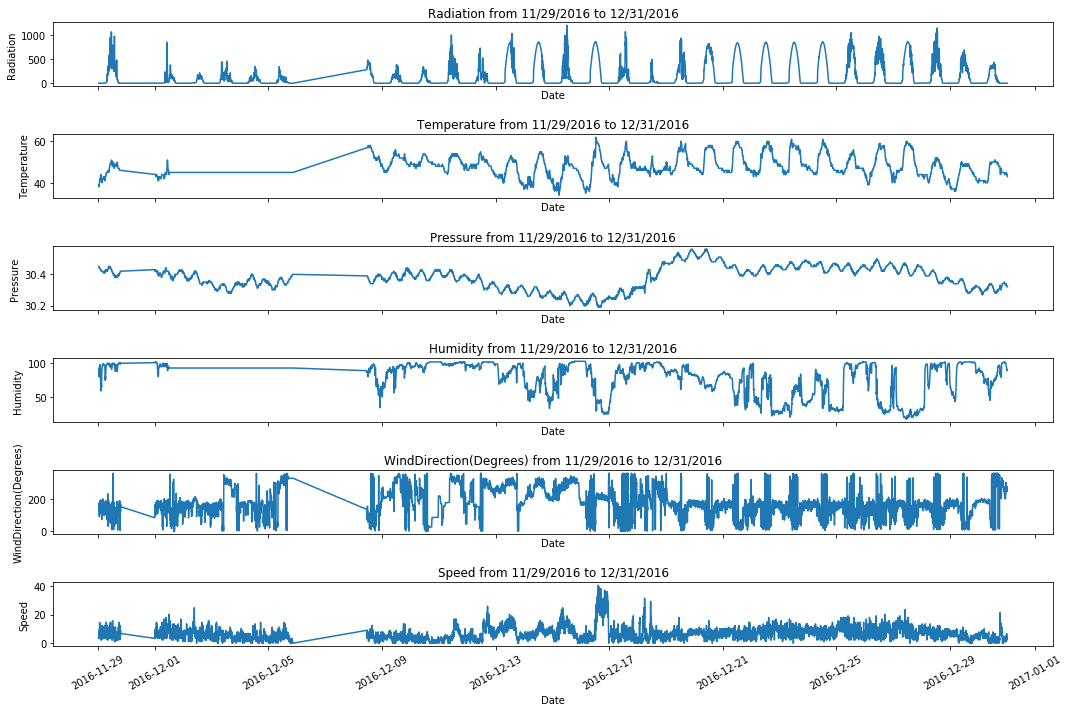

In [26]:
fig, axes = plt.subplots(len(cols), sharex=True)
for i, ax in enumerate(axes):
    ax = interval_data_plot(
        ax,
        df,
        cols[i],
        datetime.datetime(2016,11, 29).replace(tzinfo=timezone('US/Hawaii')),
        datetime.datetime(2016,12, 31).replace(tzinfo=timezone('US/Hawaii'))
    )
    
fig.tight_layout()

Sono evidenti dai grafici di dicembre che vi sono delle irregolarità nei dati, causati o da interi giorni senza rilevazioni o da righe sporche in cui i valori di alcune colonne sono stati probabilmente danneggiati.
Poichè l'irregolarità non è nello stesso periodo in tutte le colonne, decido di eliminare il periodo dal 29 Novembre al 9 Dicembre onde evitare che l'addestramento dei modelli venga contaminato dagli errori.

Negli altri periodi in cui i dati sembrano mancare ho osservato che non sono causati da corruzione dei dati, dunque non sono necessarie altre eliminazioni di righe.

In [0]:
start_date = datetime.datetime(2016,11, 29).replace(tzinfo=timezone('US/Hawaii'))
end_date = datetime.datetime(2016,12, 9).replace(tzinfo=timezone('US/Hawaii'))                                           
dfv2 = df[(df.index < start_date) | (df.index > end_date)]

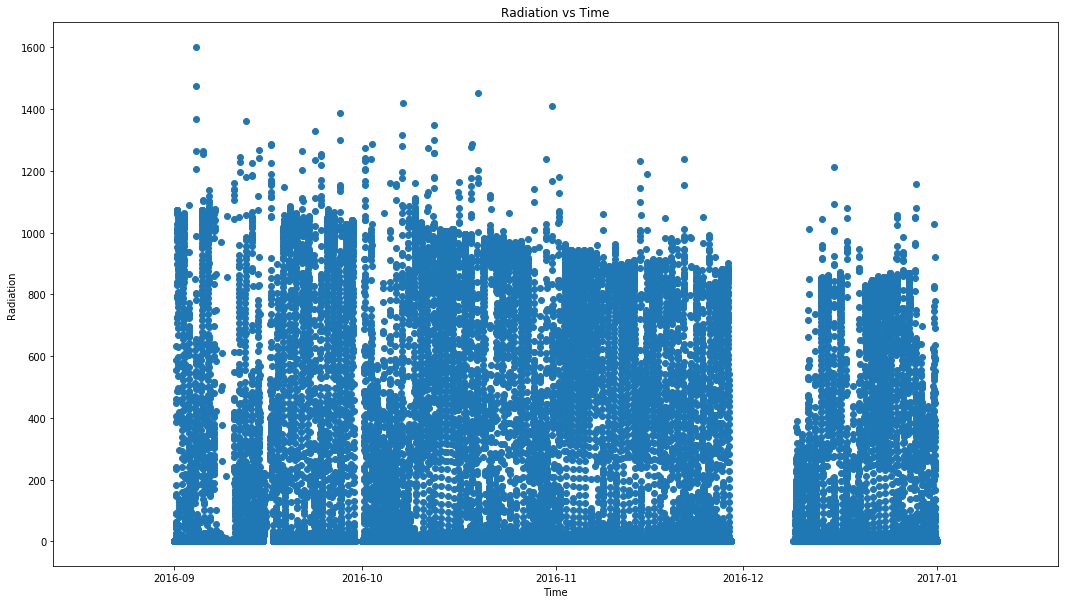

In [28]:
scatterplot(dfv2.index, dfv2["Radiation"], "Radiation vs Time", "Time", "Radiation")

Osservando i grafici in dettaglio, è possibile notare che se il sole non è nel cielo il livello di radiazioni è molto basso (quasi pari allo 0).
Di conseguenza calcolo una variabile sun_up che contiene 0 se il sole non è sorto e 1 viceversa.

In [29]:
sun_up = pd.Series((dfv2.index.time >= dfv2['TimeSunRise']) & (dfv2.index.time < dfv2['TimeSunSet'])).rename("IsDay")
sun_up.head(3)

DateTime
2016-09-01 00:00:08-10:00    False
2016-09-01 00:05:10-10:00    False
2016-09-01 00:20:06-10:00    False
Name: IsDay, dtype: bool

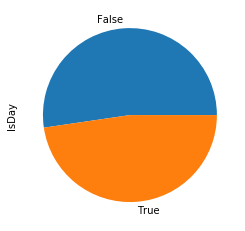

In [30]:
plt.rcParams['figure.figsize'] = 4, 4 
sun_up.value_counts().sort_index().plot.pie()

In [31]:
dfv3 = pd.concat([dfv2,sun_up], axis=1, sort=False)
dfv3.head(3)

Radiation  Temperature  ...  TimeSunSet  IsDay
DateTime                                           ...                   
2016-09-01 00:00:08-10:00       2.58           51  ...    18:38:00  False
2016-09-01 00:05:10-10:00       2.83           51  ...    18:38:00  False
2016-09-01 00:20:06-10:00       2.16           51  ...    18:38:00  False

[3 rows x 9 columns]

Creo ora anche le colonne del mese, del giorno e dell'ora (divisa per intervalli) della rilevazione.

L'anno non è influente poichè tutte le rilevazioni sono state effettuate nel 2016.

In [0]:
df_time = pd.DataFrame(dfv3.index.strftime('%m-%d-%H').str.split('-').tolist(), 
                       columns=['Month', 'Day', 'Hour'], 
                       index=dfv3.index)

df_time['Month'] = df_time['Month'].astype('uint8')
df_time['Day'] = df_time['Day'].astype('uint8')
df_time['Hour'] = pd.cut(df_time['Hour'].astype('uint8'), [0, 4, 9, 13, 18, 24], precision=0, include_lowest=True, 
                         labels=["From 0 to 4", "From 5 to 9", "From 10 to 13", "From 14 to 18", "From 19 to 23"])

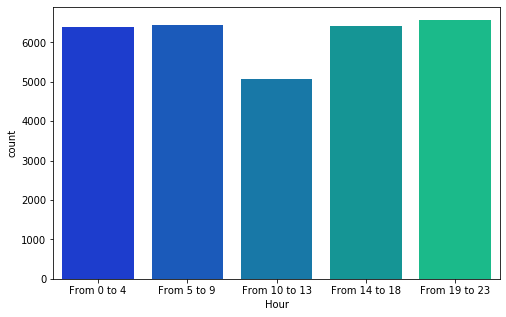

In [33]:
plt.rcParams['figure.figsize'] = 8, 5
sns.countplot(df_time['Hour'], palette='winter')

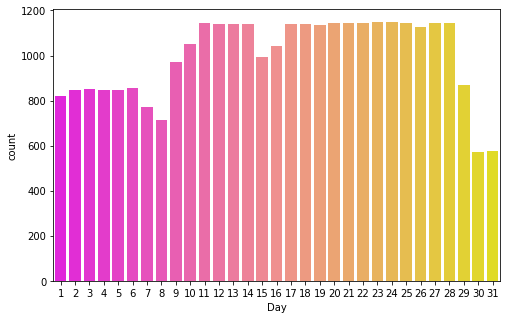

In [34]:
sns.countplot(df_time['Day'], palette='spring')

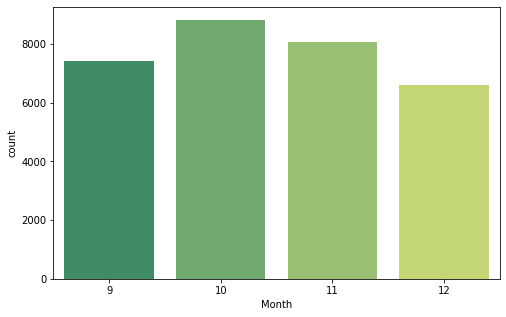

In [35]:
sns.countplot(df_time['Month'], palette='summer')

Vado infine ad creare una variabile TimeSinceSunRise che contiene quante ore sono passate dall'alba.
Se sono passati più di 30 minuti, arrotondo ad un'ora in più.

In [0]:
from datetime import date

def calculateTimeSinceSunRise(row):
    if(row.IsDay):
        final_time = datetime.datetime.combine(date.min, row.name.time()) - datetime.datetime.combine(date.min, row.TimeSunRise)
        if((final_time.seconds//60)%60 >= 30): return final_time.seconds//3600 + 1
        else: return final_time.seconds//3600
    else:
        return 0

time_since_sunrise = dfv3.apply(lambda x: calculateTimeSinceSunRise(x), axis=1).rename('TimeSinceSunRise').astype('uint8')

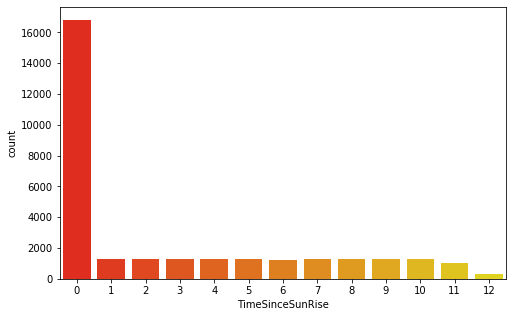

In [37]:
sns.countplot(time_since_sunrise, palette='autumn')

Creo time_indicators, che contiene tutte le informazioni temporali per ogni rilevazione.

In [38]:
time_indicators = pd.concat([df_time, time_since_sunrise], axis=1, sort=False) 

time_indicators.head(3)

Month  Day         Hour  TimeSinceSunRise
DateTime                                                            
2016-09-01 00:00:08-10:00      9    1  From 0 to 4                 0
2016-09-01 00:05:10-10:00      9    1  From 0 to 4                 0
2016-09-01 00:20:06-10:00      9    1  From 0 to 4                 0


Concateno tutte le colonne calcolate e calcolo nuovamente la correlazione di Pearson per verificare la correlazione della variabile d'interesse con quelle aggiunte.

Text(0.5, 1, 'Pearson Correlation')

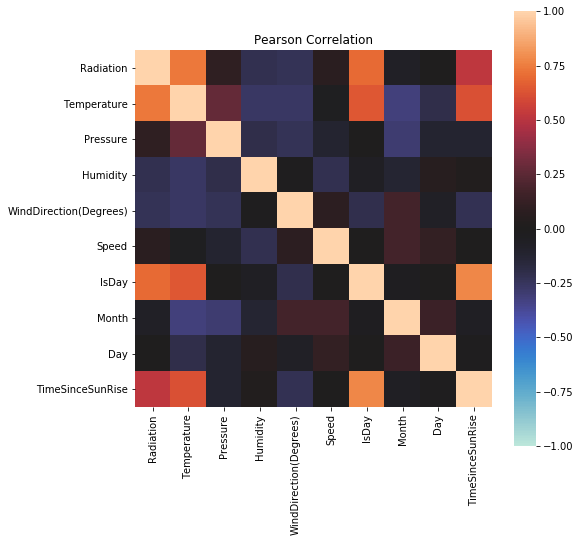

In [39]:
plt.rcParams['figure.figsize'] = 8, 8
sns.heatmap(pd.concat([dfv3, time_indicators], axis=1, sort=False).corr(), center = 0,  vmin = -1, vmax = 1 , square=True)
plt.title('Pearson Correlation')

Da questo grafico della correlazione determino che le variabili IsDay e TimeSinceSunRise sono molto direttamente correlate con la variabile da predire, mentre quelle del mese e del giorno sono poco correlate. 

Creo dunque un'ulteriore dataframe da cui elimino dunque la colonna Day, visto che è probabilmente inutile per il calcolo di predizione, e le colonne TimeSunRise e TimeSunSet, poichè le informazioni che contengono sono deducibili in maniera abbastanza approssimativa dalla colonna TimeSinceSunRise.

In [40]:
Solar_Radiation = pd.concat([dfv3, time_indicators], axis=1, sort=False).drop(['Day', 'TimeSunRise', 'TimeSunSet'], axis=1)
Solar_Radiation.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30901 entries, 2016-09-01 00:00:08-10:00 to 2016-12-31 23:55:01-10:00
Data columns (total 10 columns):
Radiation                 30901 non-null float64
Temperature               30901 non-null int64
Pressure                  30901 non-null float64
Humidity                  30901 non-null int64
WindDirection(Degrees)    30901 non-null float64
Speed                     30901 non-null float64
IsDay                     30901 non-null bool
Month                     30901 non-null uint8
Hour                      30901 non-null category
TimeSinceSunRise          30901 non-null uint8
dtypes: bool(1), category(1), float64(4), int64(2), uint8(2)
memory usage: 3.0 MB


Copio ora il dataframe in due variabili diverse allo scopo di effettuare due tipologie di studio differenti.

In [0]:
Study1 = Solar_Radiation.copy()
Study2 = Solar_Radiation.copy()

# Primo Caso Di Studio

Nel primo caso creo dei modelli addestrati su un dataframe che contiene per ogni riga solo i dati di ogni singola rilevazione.

Uso la funzione get_dummies() per convertire le colonne Month, Hour e TimeSinceSunRise in indicatori 0-1.

In [42]:
Study1v2 = pd.get_dummies(Study1, columns=['TimeSinceSunRise', 'Month', 'Hour'])

Study1v2['IsDay'] = Study1v2['IsDay'].astype('uint8')
Study1v2.head(3)

Radiation  ...  Hour_From 19 to 23
DateTime                              ...                    
2016-09-01 00:00:08-10:00       2.58  ...                   0
2016-09-01 00:05:10-10:00       2.83  ...                   0
2016-09-01 00:20:06-10:00       2.16  ...                   0

[3 rows x 29 columns]

Text(0.5, 1, 'Pearson Correlation')

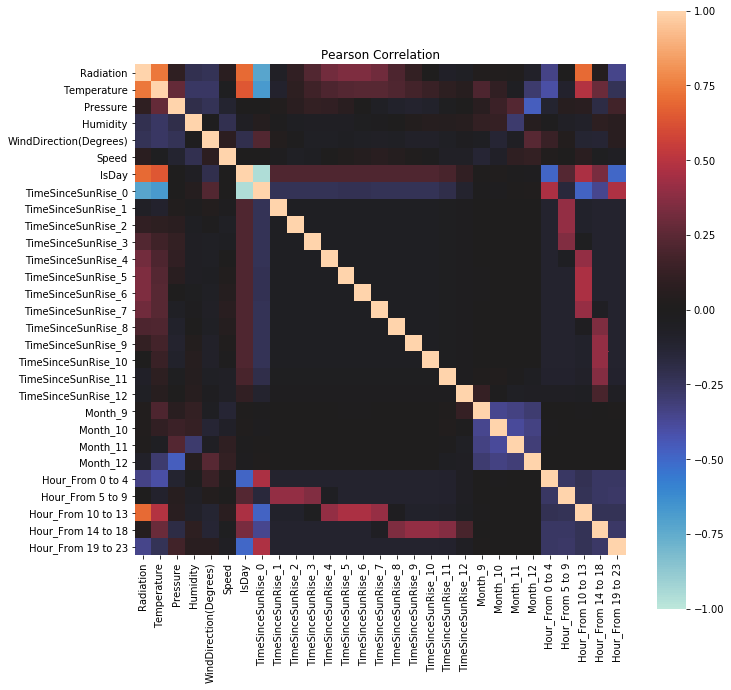

In [43]:
plt.rcParams['figure.figsize'] = 11, 11

sns.heatmap(Study1v2.corr(), center = 0,  vmin = -1, vmax = 1 , square=True)
plt.title('Pearson Correlation')

In [44]:
Study1v2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30901 entries, 2016-09-01 00:00:08-10:00 to 2016-12-31 23:55:01-10:00
Data columns (total 29 columns):
Radiation                 30901 non-null float64
Temperature               30901 non-null int64
Pressure                  30901 non-null float64
Humidity                  30901 non-null int64
WindDirection(Degrees)    30901 non-null float64
Speed                     30901 non-null float64
IsDay                     30901 non-null uint8
TimeSinceSunRise_0        30901 non-null uint8
TimeSinceSunRise_1        30901 non-null uint8
TimeSinceSunRise_2        30901 non-null uint8
TimeSinceSunRise_3        30901 non-null uint8
TimeSinceSunRise_4        30901 non-null uint8
TimeSinceSunRise_5        30901 non-null uint8
TimeSinceSunRise_6        30901 non-null uint8
TimeSinceSunRise_7        30901 non-null uint8
TimeSinceSunRise_8        30901 non-null uint8
TimeSinceSunRise_9        30901 non-null uint8
TimeSinceSunRise_10       30901 non-n

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge

Vado ora a calcolare la discesa del gradiente, per determinare un valore atteso utile come termine di confronto per l'ordine di grandezza dell'errore nei modelli che andrò a creare

In [0]:
def lr_gd_step(X1, y, theta, step_size):
    #errore per ciascun dato
    error = X1.dot(theta) - y
    # calcolo il gradiente dell'errore, ovvero la derivata parziale di ciascun parametro
    grad = (2 / X1.shape[0]) * (X1.T.dot(error))
    # calcolo i nuovi parametri
    new_theta = theta - step_size * grad
    return new_theta

In [0]:
y = Study1v2["Radiation"].values
X = Study1v2.drop(columns=["Radiation"]).values

X1 = np.hstack([np.ones((X.shape[0], 1)), X])

In [0]:
theta = np.zeros(X1.shape[1])
theta_vals = [theta]
for iteration in range(10000):
    theta = lr_gd_step(X1, y, theta, 0.000025)
    theta_vals.append(theta)
theta_vals = np.array(theta_vals)

In [0]:
mse_vals = np.mean(np.square(X1.dot(theta_vals.T) - y[:, None]), axis=0)

Text(0, 0.5, 'MSE')

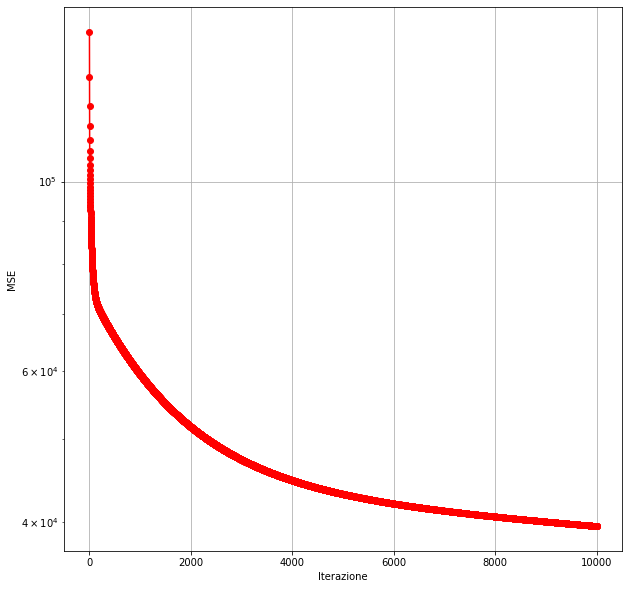

In [55]:
plt.rcParams['figure.figsize'] = 10, 10 
plt.semilogy(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("MSE")

In [56]:
mse_vals.min()

39565.91044867831

Dal grafico si deduce che gli mse migliori saranno di ordine 10^4.

Creo delle funzioni per confrontare i modelli che andrò a costruire.

In [0]:
def compareModel(X_test, y_val, model):

    print_eval(X_test, y_val, model)
    y_pred = model.predict(X_test)
    
    #plot creation
    plt.rcParams['figure.figsize'] = 10, 8
    plt.plot(X_test.index, y_pred, c='blue', label='Predetto')
    plt.plot(y_val.index, y_val, c='red', label='Osservato')
    plt.title('Predetto vs Osservato')
    plt.ylabel('Radiation')
    plt.xlabel('Date');
    
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))
    
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(model.predict(X), y)))
    print("       Relative error: {:.5%}".format(relative_error(model.predict(X), y)))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))

Vado ora a creare il primo modello con regressione lineare, applicando la standardizzazione poichè le variabili hanno intervalli di dominio molto diversi fra loro.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    Study1v2.drop("Radiation", axis=1),
    Study1v2["Radiation"],
    test_size=1/3, random_state=42   # parametri divisione
)

   Mean squared error: 1.7223e+04
       Relative error: 98.99559%
R-squared coefficient: 0.83296


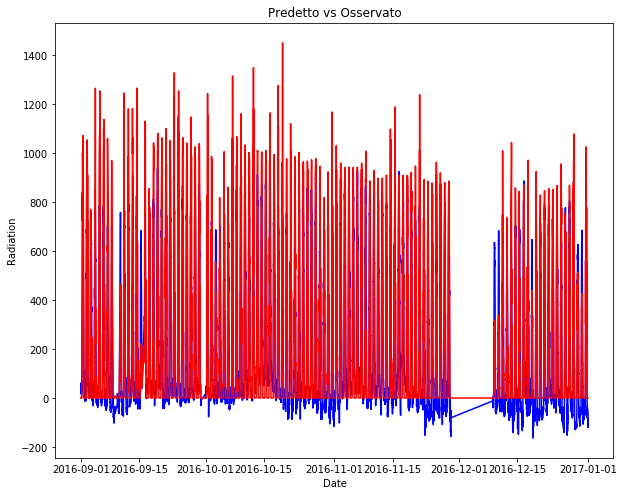

In [136]:
prm = Pipeline([
    # nome     elemento
    ("scale", StandardScaler()),
    ("linreg", LinearRegression())
])

prm.fit(X_train, y_train)

compareModel(X_val.sort_index(), y_val.sort_index(), prm)

In [48]:
pd.Series(prm.named_steps['linreg'].coef_, index=X_train.columns)

Temperature               8.908923e+01
Pressure                 -2.142876e+01
Humidity                 -2.389924e+01
WindDirection(Degrees)   -1.465933e+01
Speed                     6.240802e+00
IsDay                     5.010784e+00
TimeSinceSunRise_0        1.457497e+13
TimeSinceSunRise_1        5.810395e+12
TimeSinceSunRise_2        5.830077e+12
TimeSinceSunRise_3        5.859453e+12
TimeSinceSunRise_4        5.846419e+12
TimeSinceSunRise_5        5.803816e+12
TimeSinceSunRise_6        5.754194e+12
TimeSinceSunRise_7        5.891889e+12
TimeSinceSunRise_8        5.780722e+12
TimeSinceSunRise_9        5.690603e+12
TimeSinceSunRise_10       5.849680e+12
TimeSinceSunRise_11       5.186288e+12
TimeSinceSunRise_12       2.870933e+12
Month_9                   2.057763e+13
Month_10                  2.166103e+13
Month_11                  2.115242e+13
Month_12                  1.972434e+13
Hour_From 0 to 4          5.442196e+13
Hour_From 5 to 9          5.443125e+13
Hour_From 10 to 13       

Usando il modello lineare noto che il valore ottenuto di R^2 è abbastanza buono, ma l'errore è alto e quindi può essere migliorato.
Noto però che i coefficienti calcolati hanno valori molto alti, perciò provo ad usare la normalizzazione.

Definisco la funzione test_grid() per testare i modelli con diversi parametri tramite la grid search.

In [0]:
def test_grid(model, grid):
    gs = GridSearchCV(model, param_grid=grid, cv=3)
    gs.fit(X_train, y_train)
    print(gs.best_params_)
    print_eval(X_val, y_val, gs)

In [137]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Lasso(max_iter=150))
])
grid = {
    "linreg__alpha":    [0.01, 0.5, 1, 1.5, 3, 5, 10 ,30 ,50, 70, 100],
} 

test_grid(model, grid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7348784.3437424, tolerance: 143016.31583752518
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1085533.647260487, tolerance: 141434.4213078861
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7309266.250812143, tolerance: 142013.36220251204
  positive)


{'linreg__alpha': 0.01}
   Mean squared error: 1.7223e+04
       Relative error: 82.20271%
R-squared coefficient: 0.83296


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3567638.019249618, tolerance: 213232.77102531222
  positive)


In [138]:
prm = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Lasso(alpha=0.01, max_iter=150))
])

prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)
pd.Series(prm.named_steps['linreg'].coef_, index=X_train.columns)

   Mean squared error: 1.7223e+04
       Relative error: 82.20271%
R-squared coefficient: 0.83296


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3567638.019249618, tolerance: 213232.77102531222
  positive)


Temperature                89.200590
Pressure                  -21.385493
Humidity                  -23.890772
WindDirection(Degrees)    -14.651837
Speed                       6.231183
IsDay                       4.916610
TimeSinceSunRise_0       -161.177562
TimeSinceSunRise_1        -48.890014
TimeSinceSunRise_2        -12.635348
TimeSinceSunRise_3         16.820985
TimeSinceSunRise_4         39.927947
TimeSinceSunRise_5         46.549748
TimeSinceSunRise_6         43.743973
TimeSinceSunRise_7         31.079523
TimeSinceSunRise_8         14.691520
TimeSinceSunRise_9         -7.182945
TimeSinceSunRise_10       -37.991454
TimeSinceSunRise_11       -54.068976
TimeSinceSunRise_12       -35.436752
Month_9                    -0.843365
Month_10                    3.187989
Month_11                    6.741660
Month_12                   -6.344498
Hour_From 0 to 4            6.614614
Hour_From 5 to 9            9.476018
Hour_From 10 to 13         11.831655
Hour_From 14 to 18        -16.729914
H

Nel test con la regressione Lasso l'errore migliora leggermente, ma ancora non è un risultato sufficiente.

Nessuno dei coefficienti viene annullato: ne deduco dunque che non vi è collinearità. Noto inoltre l'importanza della temperatura (come avevamo notato in precedenza) e degli intervalli centrali in 'TimeSinceSunRise' e 'Hours', probabilmente perchè il sole è più in alto ed emette più radiazioni in quei momenti.
Provo ad usare la regressione Ridge.

In [139]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Ridge(max_iter=150))
])
grid = {
    "linreg__alpha":    [0.01, 0.5, 1, 1.5, 3, 5, 10, 30, 50, 70, 100],
} 

test_grid(model, grid)

{'linreg__alpha': 10}
   Mean squared error: 1.7222e+04
       Relative error: 84.92633%
R-squared coefficient: 0.83296


In [140]:
prm = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Ridge(alpha=10, max_iter=150))
])

prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)
pd.Series(prm.named_steps['linreg'].coef_, index=X_train.columns)

   Mean squared error: 1.7222e+04
       Relative error: 84.92633%
R-squared coefficient: 0.83296


Temperature                89.200771
Pressure                  -21.389917
Humidity                  -23.893725
WindDirection(Degrees)    -14.666429
Speed                       6.237711
IsDay                       5.628679
TimeSinceSunRise_0       -105.047880
TimeSinceSunRise_1        -26.755834
TimeSinceSunRise_2          9.556650
TimeSinceSunRise_3         39.105543
TimeSinceSunRise_4         61.963528
TimeSinceSunRise_5         68.394782
TimeSinceSunRise_6         65.402693
TimeSinceSunRise_7         53.277776
TimeSinceSunRise_8         36.596743
TimeSinceSunRise_9         14.389657
TimeSinceSunRise_10       -15.801027
TimeSinceSunRise_11       -34.386073
TimeSinceSunRise_12       -24.541750
Month_9                    -1.671859
Month_10                    2.328066
Month_11                    5.899238
Month_12                   -7.138823
Hour_From 0 to 4            4.402403
Hour_From 5 to 9            7.184763
Hour_From 10 to 13         10.186507
Hour_From 14 to 18        -18.824199
H

Con la regressione Ridge l'errore relativo peggiora leggermente.
Provo ora ad usare il compromesso fra i due algoritmi, ovvero l'Elastic Net.

In [54]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", ElasticNet(max_iter=150))
])
grid = {
    "linreg__alpha":    [0.01, 0.5, 1, 1.5, 3, 5, 10, 30, 50, 70, 100],
    "linreg__l1_ratio": np.linspace(0,1,num=11, endpoint=True)
} 

test_grid(model, grid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 124989036.36936024, tolerance: 143016.31583752518
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 128876193.02344263, tolerance: 141434.4213078861
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125225551.09879519, tolerance: 142013.36220251204
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1215826

{'linreg__alpha': 0.01, 'linreg__l1_ratio': 0.8}
   Mean squared error: 1.7222e+04
       Relative error: 85.08682%
R-squared coefficient: 0.83296


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162761057.3552586, tolerance: 213232.77102531222
  positive)


In [55]:
prm = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", ElasticNet(max_iter=150, alpha=0.01, l1_ratio=0.8))
])


prm.fit(X_train, y_train)
print_eval(X_val, y_val, prm)
pd.Series(prm.named_steps['linreg'].coef_, index=X_train.columns)

   Mean squared error: 1.7222e+04
       Relative error: 85.08682%
R-squared coefficient: 0.83296


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162761057.3552586, tolerance: 213232.77102531222
  positive)


Temperature                89.012622
Pressure                  -21.250188
Humidity                  -23.915122
WindDirection(Degrees)    -14.651123
Speed                       6.237701
IsDay                       6.596172
TimeSinceSunRise_0       -136.005367
TimeSinceSunRise_1        -39.398189
TimeSinceSunRise_2         -3.153014
TimeSinceSunRise_3         26.204061
TimeSinceSunRise_4         48.434493
TimeSinceSunRise_5         54.873672
TimeSinceSunRise_6         52.014145
TimeSinceSunRise_7         39.665119
TimeSinceSunRise_8         23.764976
TimeSinceSunRise_9          1.861889
TimeSinceSunRise_10       -28.625859
TimeSinceSunRise_11       -45.735218
TimeSinceSunRise_12       -30.815017
Month_9                    -1.078687
Month_10                    2.912829
Month_11                    6.431426
Month_12                   -6.575445
Hour_From 0 to 4            5.618645
Hour_From 5 to 9            8.343714
Hour_From 10 to 13         12.750139
Hour_From 14 to 18        -17.354743
H

Anche in questo caso l'errore relativo peggiora leggermente, di conseguenza provo ad usare la Polynomial Features su tutte e tre i tipi di normalizzazioni, e definisco una funzione che ritorna l'R^2 e l'errore relativo del modello.

In [56]:
model = Pipeline([
  ("poly",  PolynomialFeatures(include_bias=False)),
  ("scale", StandardScaler()),
  ("linreg", Lasso())
])

grid = {
    "poly__degree": range(2, 4),
    "linreg__alpha": [0.01, 0.5, 1, 1.5, 3]
} 

test_grid(model, grid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51254023.37914085, tolerance: 143016.31583752518
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52750993.80507662, tolerance: 141434.4213078861
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58585128.899134405, tolerance: 142013.36220251204
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56703043.

{'linreg__alpha': 0.01, 'poly__degree': 3}
   Mean squared error: 1.178e+04
       Relative error: 115.30963%
R-squared coefficient: 0.88574


In [0]:
def test_regression(degree, alpha):
    model = Pipeline([
        ("poly",  PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("linreg", Lasso(alpha=alpha))
    ])
    model.fit(X_train, y_train)
    return model.score(X_val, y_val), (np.mean(np.abs((model.predict(X_val) - y_val) / model.predict(X_val))))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1580397.52079767, tolerance: 213232.77102531222
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83152078.4778363, tolerance: 213232.77102531222
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 90851031.38225348, tolerance: 213232.77102531222
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78641212.81

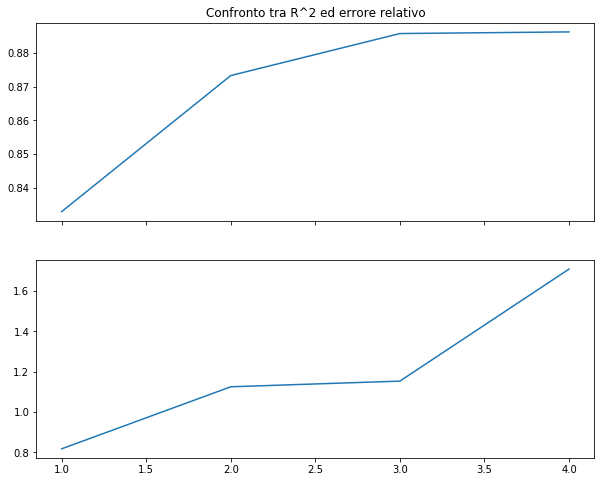

In [58]:
degrees = range(1, 5, 1)
temp = [test_regression(d,0.01) for d in degrees]
scores = [temp[d - 1][0] for d in degrees]
e_rel = [temp[d - 1][1] for d in degrees]
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(degrees, scores)
axarr[0].set_title('Confronto tra R^2 ed errore relativo')
axarr[1].plot(degrees, e_rel)

In [60]:
scores[2], e_rel[2]

(0.8857431463947043, 1.1530962689233726)

Provo ora ad usare il polinomio con la regressione Ridge.

In [62]:
model = Pipeline([
  ("poly",  PolynomialFeatures(include_bias=False)),
  ("scale", StandardScaler()),
  ("linreg", Ridge())
])

grid = {
    "poly__degree": range(2, 4),
    "linreg__alpha": [0.01, 0.5, 1, 1.5, 3, 10, 30, 50, 70]
} 

test_grid(model, grid)

{'linreg__alpha': 0.5, 'poly__degree': 3}
   Mean squared error: 1.1651e+04
       Relative error: 116.48151%
R-squared coefficient: 0.887


In [0]:
def test_regression(degree, alpha):
    model = Pipeline([
        ("poly",  PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("linreg", Ridge(alpha=alpha))
    ])
    model.fit(X_train, y_train)
    return model.score(X_val, y_val), (np.mean(np.abs((model.predict(X_val) - y_val) / model.predict(X_val))))

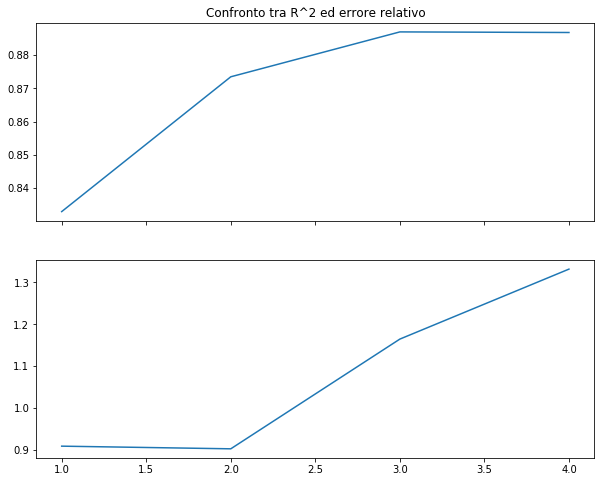

In [142]:
degrees = range(1, 5, 1)
temp = [test_regression(d,0.5) for d in degrees]
scores = [temp[d - 1][0] for d in degrees]
e_rel = [temp[d - 1][1] for d in degrees]
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(degrees, scores)
axarr[0].set_title('Confronto tra R^2 ed errore relativo')
axarr[1].plot(degrees, e_rel)

In [143]:
scores[1], e_rel[1]

(0.8735018558527226, 0.9026804873914016)

Poichè dai grafici sembra che all'aumentare del grado R^2 continui ad aumentare e l'errore relativo diminuisca provo ad usare il Kernel Ridge per calcolare i risultati con gradi più alti.

In [0]:
def test_regression(degree, alpha):
    model = Pipeline([
        ("scale", StandardScaler()),
        ("linreg", KernelRidge(kernel="poly", alpha=alpha, degree=degree))  
    ])
    model.fit(X_train, y_train)
    return model.score(X_val, y_val), np.mean(np.abs((model.predict(X_val) - y_val) / model.predict(X_val)))

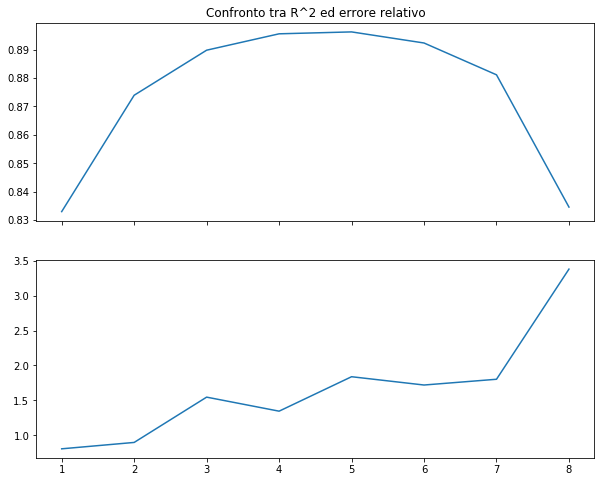

In [74]:
degrees = range(1, 9, 1)
temp = [test_regression(d,0.5) for d in degrees]
scores = [temp[d - 1][0] for d in degrees]
e_rel = [temp[d - 1][1] for d in degrees]
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(degrees, scores)
axarr[0].set_title('Confronto tra R^2 ed errore relativo')
axarr[1].plot(degrees, e_rel)

In [83]:
pd.DataFrame([[scores[1], e_rel[1]], [scores[3], e_rel[3]]], index=['Grado 2', 'Grado 4'], columns=['R^2', 'Errore Relativo'])

R^2  Errore Relativo
Grado 2  0.873956         0.897228
Grado 4  0.895599         1.345408

A partire dal quarto grado R^2 diminuisce e l'errore relativo aumenta poichè si rientra nel caso dell'overfitting, di conseguenza non è necessario continuare. Scelgo dunque come grado migliore con la regressione ridge il secondo grado, poichè è un giusto compromesso tra l'aumento di R^2 e il peggioramento nell'errore relativo.
Il quarto grado non è preferibile poichè il guadagno di 0.02 nell'R^2 non è significativo quanto l'aumento di 0,4 nell'errore relativo.

Provo ora ad usare l'Elastic Net.

In [68]:
model = Pipeline([
  ("poly",  PolynomialFeatures(include_bias=False)),
  ("scale", StandardScaler()),
  ("linreg", ElasticNet())
])

grid = {
    "poly__degree": range(2, 4),
    "linreg__alpha": [0.01, 0.5, 1, 1.5, 3],
    "linreg__l1_ratio": [0.1, 0.5, 0.8, 1]
} 

test_grid(model, grid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94280316.71840088, tolerance: 143016.31583752518
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 95931821.63389513, tolerance: 141434.4213078861
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93457410.31477502, tolerance: 142013.36220251204
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81426140.6

{'linreg__alpha': 0.01, 'linreg__l1_ratio': 1, 'poly__degree': 3}
   Mean squared error: 1.178e+04
       Relative error: 115.30963%
R-squared coefficient: 0.88574


Poichè l1_ratio migliore con polinomiale è 1 (e dunque è equivalente alla regressione lasso), non calcolo il grafico al variare del grado in questo caso. I test effettuati con il kernel Rbf non hanno dato risultati migliori.


Il modello che reputo un giusto compromesso tra l'affidabilità e la quantità di errore è quello con Regressione Ridge (alpha = 0.5) e feature polinomiale (secondo grado). Decido di usare la suddivisione Kfold per determinare in maniera in maniera più affidabile l'R^2 e l'errore relativo di questo modello, poichè la ritengo la migliore per questo caso di studio.

Utilizzo la classe make_scorer per effettuare la KFold usando come criterio l'errore quadratico medio più basso.

In [0]:
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

In [0]:
y1 = Study1v2["Radiation"].values
X1 = Study1v2.drop(columns=["Radiation"]).values

In [0]:
kf = KFold(5, shuffle=True, random_state=42)
finalModel1 = Pipeline([
        ("poly",  PolynomialFeatures(degree=2, include_bias=False)),
        ("scale", StandardScaler()),
        ("linreg", Ridge(alpha=0.5))
])

In [0]:
scores = cross_val_score(finalModel1, X1, y1, cv=kf)

In [0]:
mse_low = make_scorer(mean_squared_error)
MSE= cross_val_score(finalModel1, X1, y1,scoring = mse_low, cv=kf)

In [134]:
pd.DataFrame([np.append(scores, [scores.mean(), scores.std()]) , np.append(MSE, [MSE.mean(), MSE.std()])], 
             index=['R^2', 'MSE'], columns=np.append(range(1,6), ['Mean', 'Std']))

1             2  ...          Mean         Std
R^2      0.871837      0.872753  ...      0.870366    0.002811
MSE  13060.065634  13193.891913  ...  13401.502587  398.210283

[2 rows x 7 columns]

# Secondo Caso Di Studio

Nel secondo caso di studio modificando il database iniziale in maniera diversa, aggiungendo su ogni riga le informazioni della rilevazione precedente.

In [58]:
Study2.head(3)

Radiation  ...  TimeSinceSunRise
DateTime                              ...                  
2016-09-01 00:00:08-10:00       2.58  ...                 0
2016-09-01 00:05:10-10:00       2.83  ...                 0
2016-09-01 00:20:06-10:00       2.16  ...                 0

[3 rows x 10 columns]

Creo una colonna che mi indica quanto tempo è passato dall'ultima misurazione. Seleziono solo quelle dove l'intervallo non è maggiore di mezz'ora, e lo converto in secondi.

In [59]:
Study2v2 = Study2.copy()
Study2v2['Last Rilevation'] = Study2v2.index
Study2v2['Last Rilevation'] = Study2v2.index - Study2v2['Last Rilevation'].shift(1)

Study2v2 = Study2v2[Study2v2['Last Rilevation'] <= datetime.timedelta(minutes=30)]
Study2v2['Last Rilevation'] = [time.seconds for time in Study2v2['Last Rilevation']]
Study2v2['Last Rilevation']

DateTime
2016-09-01 00:05:10-10:00    302
2016-09-01 00:20:06-10:00    896
2016-09-01 00:25:05-10:00    299
2016-09-01 00:30:09-10:00    304
2016-09-01 00:45:04-10:00    895
                            ... 
2016-12-31 23:35:02-10:00    300
2016-12-31 23:40:01-10:00    299
2016-12-31 23:45:04-10:00    303
2016-12-31 23:50:03-10:00    299
2016-12-31 23:55:01-10:00    298
Name: Last Rilevation, Length: 30871, dtype: int64

In [60]:
Study2v2['Last Rilevation'].describe()

count    30871.000000
mean       303.777655
std         47.054518
min          1.000000
25%        298.000000
50%        300.000000
75%        302.000000
max       1800.000000
Name: Last Rilevation, dtype: float64

In [61]:
print(Study2.shape[0] - Study2v2.shape[0])

30


Togliendo le righe in cui l'ultima rilevazione è avvenuta più di 30 minuti prima ho eliminato solo 30 righe, quindi non ho modificato in maniera sostanziale i dati.

Aggiungo ora per ogni riga i dati della rilevazione precendente usando il metodo shift().

In [62]:
Study2v3 = Study2v2.copy()
for i in ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']:
    Study2v3["{} Lag1".format(i)] = Study2v3[i].shift(1) * Study2v3['Last Rilevation'] * Study2v3['IsDay']

Study2v3.dropna(inplace=True)
Study2v3.head(3)

Radiation  ...  Speed Lag1
DateTime                              ...            
2016-09-01 00:20:06-10:00       2.16  ...         0.0
2016-09-01 00:25:05-10:00       2.21  ...         0.0
2016-09-01 00:30:09-10:00       2.25  ...         0.0

[3 rows x 17 columns]

Elimino la colonna TimeSinceSunRise, poichè non mi interessa in questo caso di studio.

In [63]:
Study2v4 = pd.get_dummies(Study2v3, columns=['Month', 'Hour'])
del Study2v4['TimeSinceSunRise']

Study2v4.head(3)

Radiation  ...  Hour_From 19 to 23
DateTime                              ...                    
2016-09-01 00:20:06-10:00       2.16  ...                   0
2016-09-01 00:25:05-10:00       2.21  ...                   0
2016-09-01 00:30:09-10:00       2.25  ...                   0

[3 rows x 23 columns]

Text(0.5, 1, 'Pearson Correlation')

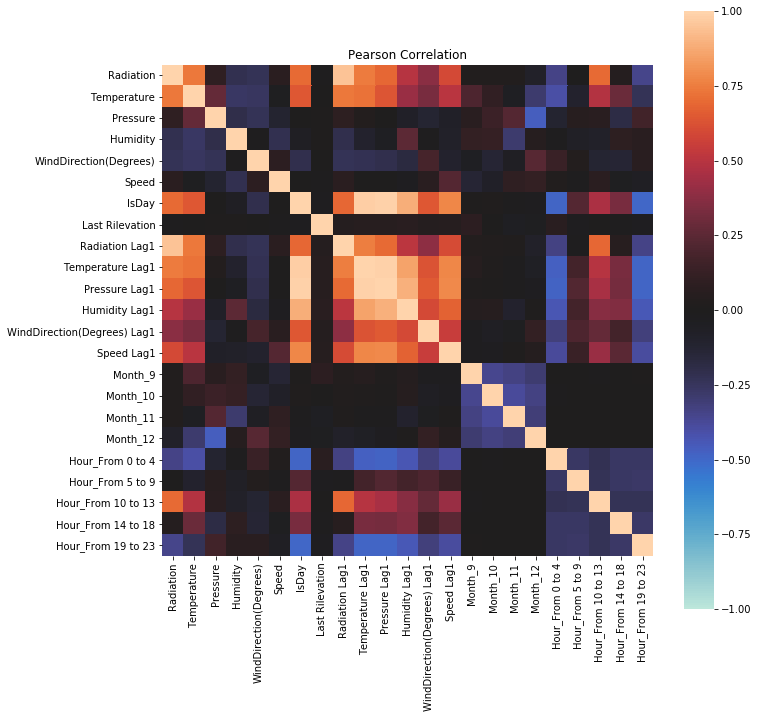

In [64]:
plt.rcParams['figure.figsize'] = 11, 11

sns.heatmap(Study2v4.corr(), center = 0,  vmin = -1, vmax = 1 , square=True)
plt.title('Pearson Correlation')

Dal grafico della correlazione di Pearson posso già intuire che i dati inerenti alla rilevazione precedente saranno molto influenti per la previsione del livello di radiazioni.

Anche in questo caso calcolo la discesa del gradiente per avere un'idea dell'ordine di grandezza dell'errore.

In [0]:
y = Study2v4["Radiation"].values
X = Study2v4.drop(columns=["Radiation"]).values

X1 = np.hstack([np.ones((X.shape[0], 1)), X])

In [0]:
theta = np.zeros(X1.shape[1])
theta_vals = [theta]
for iteration in range(100):
    theta = lr_gd_step(X1, y, theta, 0.00000000001)
    theta_vals.append(theta)
theta_vals = np.array(theta_vals)

In [0]:
mse_vals = np.mean(np.square(X1.dot(theta_vals.T) - y[:, None]), axis=0)

Text(0, 0.5, 'MSE')

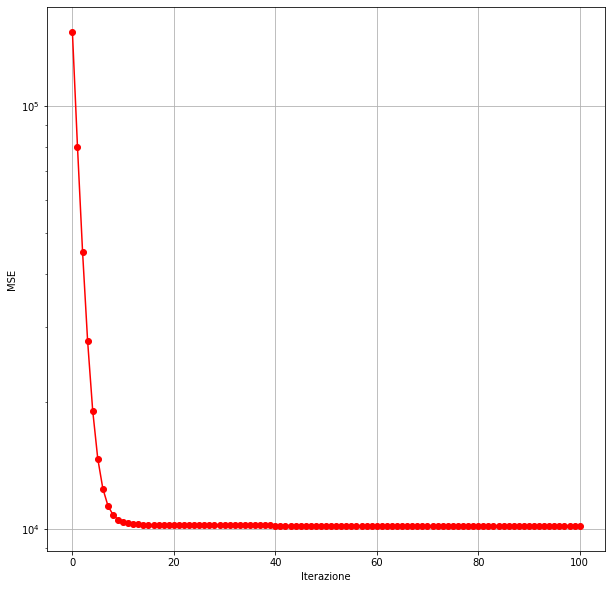

In [68]:
plt.rcParams['figure.figsize'] = 10, 10 
plt.semilogy(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("MSE")

In [69]:
np.min(mse_vals)

10161.452799469973

L'ordine di grandezza dell'errore quadratico medio è sempre di 10^4.

Inizio a testare i modelli.

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    Study2v4.drop("Radiation", axis=1),
    Study2v4["Radiation"],
    test_size=1/3, random_state=42   # parametri divisione
)

   Mean squared error: 8014.4
       Relative error: 298.73780%
R-squared coefficient: 0.92158


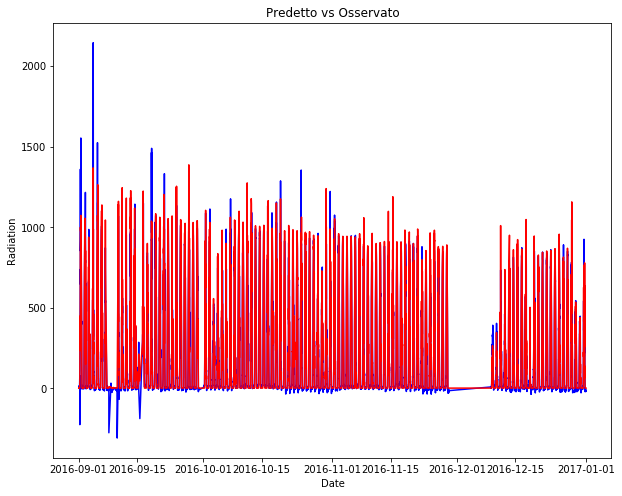

In [193]:
prm = Pipeline([
    # nome     elemento
    ("scale", StandardScaler()),
    ("linreg", LinearRegression())
])

prm.fit(X_train, y_train)

compareModel(X_val.sort_index(), y_val.sort_index(), prm)

In [194]:
pd.Series(prm.named_steps['linreg'].coef_, index=X_train.columns)

Temperature                     20.744471
Pressure                        -3.818233
Humidity                        -0.880121
WindDirection(Degrees)          -2.059901
Speed                           -0.218402
IsDay                          177.233424
Last Rilevation                 -0.041155
Radiation Lag1                 255.890651
Temperature Lag1                51.714602
Pressure Lag1                 -196.975046
Humidity Lag1                   -7.093838
WindDirection(Degrees) Lag1     -4.963137
Speed Lag1                       3.524557
Month_9                         -2.902822
Month_10                        -0.345934
Month_11                         2.157176
Month_12                         1.095581
Hour_From 0 to 4                -1.956913
Hour_From 5 to 9                 2.541720
Hour_From 10 to 13              18.642892
Hour_From 14 to 18             -13.690399
Hour_From 19 to 23              -4.045245
dtype: float64

La regressione lineare non è efficiente, proseguo dunque usando la normalizzazione.

In [195]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Lasso(max_iter=150))
])
grid = {
    "linreg__alpha":    [0.001, 0.01, 0.5, 1, 1.5, 3, 5, 10 ,30 ,50, 70, 100],
} 

test_grid(model, grid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60333804.79080735, tolerance: 143556.97595811955
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58916883.95319316, tolerance: 141772.4076235976
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53663592.83969229, tolerance: 142055.56182887024
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57366861.9

{'linreg__alpha': 0.5}
   Mean squared error: 8132.9
       Relative error: 93.08376%
R-squared coefficient: 0.92043


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1403688.66885823, tolerance: 213701.25018098383
  positive)


In [196]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Lasso(max_iter=150))
])

model.fit(X_train, y_train)
pd.Series(model.named_steps['linreg'].coef_, index=X_train.columns)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 793609.1877028048, tolerance: 213701.25018098383
  positive)


Temperature                     22.335441
Pressure                        -2.290046
Humidity                        -0.000000
WindDirection(Degrees)          -0.516256
Speed                            0.134127
IsDay                           91.277607
Last Rilevation                 -7.003479
Radiation Lag1                 255.250790
Temperature Lag1                -0.000000
Pressure Lag1                  -48.180233
Humidity Lag1                  -18.203685
WindDirection(Degrees) Lag1     -5.570429
Speed Lag1                       0.000000
Month_9                         -2.047951
Month_10                        -0.000000
Month_11                         0.428287
Month_12                         0.000000
Hour_From 0 to 4                 0.000000
Hour_From 5 to 9                 2.554070
Hour_From 10 to 13              22.377611
Hour_From 14 to 18              -9.054606
Hour_From 19 to 23              -2.259937
dtype: float64

Vediamo che con la regressione Lasso alcuni coefficienti sono stati annullati. Inoltre notiamo che , come avevamo intuito, il livello di radiazioni registrato nella rilevazione precedente ha una grande importanza nel modello.

In [197]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", Ridge(max_iter=150))
])
grid = {
    "linreg__alpha":    [0, 0.001, 0.01, 0.5, 1, 1.5, 3, 5, 10 ,30 ,50, 70, 100],
} 

test_grid(model, grid)

{'linreg__alpha': 30}
   Mean squared error: 8066.3
       Relative error: 116.83250%
R-squared coefficient: 0.92108


In [198]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("linreg", ElasticNet(max_iter=150))
])
grid = {
    "linreg__alpha":    [0, 0.001, 0.01, 0.5, 1, 1.5, 3, 5, 10],
    "linreg__l1_ratio": [0, 0.3, 0.5, 0.7, 1]
} 

test_grid(model, grid)

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60656109.345182255, tolerance: 143556.97595811955
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coo

{'linreg__alpha': 0.01, 'linreg__l1_ratio': 0.7}
   Mean squared error: 8109.0
       Relative error: 91.47088%
R-squared coefficient: 0.92066


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80264104.80647703, tolerance: 213701.25018098383
  positive)


In [200]:
model = Pipeline([
    ("scale", StandardScaler()),
      ("linreg", ElasticNet(alpha=0.01, l1_ratio=0.7, max_iter=150))
])

model.fit(X_train, y_train)
pd.Series(model.named_steps['linreg'].coef_, index=X_train.columns)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80264104.80647703, tolerance: 213701.25018098383
  positive)


Temperature                     30.983448
Pressure                        -4.948983
Humidity                         0.075482
WindDirection(Degrees)          -2.145900
Speed                            0.486781
IsDay                          139.668650
Last Rilevation                 -2.831886
Radiation Lag1                 255.160825
Temperature Lag1               -23.667388
Pressure Lag1                  -82.590233
Humidity Lag1                  -15.173616
WindDirection(Degrees) Lag1     -6.272912
Speed Lag1                       1.921904
Month_9                         -3.262311
Month_10                        -0.839169
Month_11                         1.953978
Month_12                         0.931153
Hour_From 0 to 4                -0.942670
Hour_From 5 to 9                 2.710137
Hour_From 10 to 13              20.912967
Hour_From 14 to 18             -12.610070
Hour_From 19 to 23              -4.414513
dtype: float64

L'Elastic Net è la forma di normalizzazione più efficiente, poichè con essa diminuisce l'errore relativo e aumenta leggermente R^2.

Introduco le features polinomiali per rendere più aderente il modello ai dati.

In [202]:
model = Pipeline([
  ("poly",  PolynomialFeatures(include_bias=False)),
  ("scale", StandardScaler()),
  ("linreg", ElasticNet())
])

grid = {
    "poly__degree": range(1, 4),
    "linreg__alpha": [0.01, 0.5, 1, 1.5, 3],
    "linreg__l1_ratio": [0, 0.3, 0.5, 0.7, 1]
} 

test_grid(model, grid)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66385076.34412004, tolerance: 143556.97595811955
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64794635.4305527, tolerance: 141772.4076235976
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60400773.70319263, tolerance: 142055.56182887024
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51567842.45

{'linreg__alpha': 0.5, 'linreg__l1_ratio': 1, 'poly__degree': 3}
   Mean squared error: 6812.4
       Relative error: 181.83169%
R-squared coefficient: 0.93335


La scelta di l1_ratio uguale ad 1 dimostra che, nel caso dell'utilizzo della feature polinomiale, il risultato migliore equivale a quello della regressione Lasso. 

Vado perciò a studiare la viariazione di R^2 e dell'errore relativo al variare del grado solo con l'utilizzo della Lasso.

In [0]:
def test_regression(degree, alpha):
    model = Pipeline([
        ("poly",  PolynomialFeatures(degree=degree, include_bias=False)),
        ("scale", StandardScaler()),
        ("linreg", Lasso(alpha=alpha))
    ])
    model.fit(X_train, y_train)
    return model.score(X_val, y_val), (np.mean(np.abs((model.predict(X_val) - y_val) / model.predict(X_val))))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523771.4461198449, tolerance: 213701.25018098383
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471313.7212572396, tolerance: 213701.25018098383
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 481887.92139573395, tolerance: 213701.25018098383
  positive)


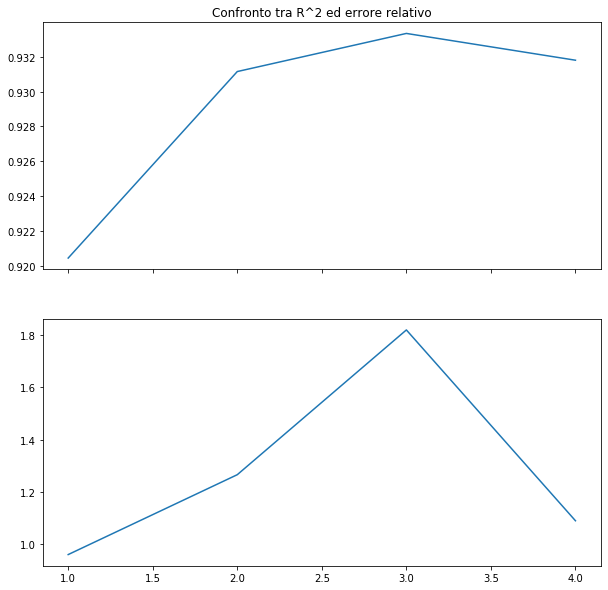

In [72]:
degrees = range(1, 5, 1)
temp = [test_regression(d,0.5) for d in degrees]
scores = [temp[d - 1][0] for d in degrees]
e_rel = [temp[d - 1][1] for d in degrees]
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(degrees, scores)
axarr[0].set_title('Confronto tra R^2 ed errore relativo')
axarr[0].ylabel = "R^2"
axarr[1].plot(degrees, e_rel)
axarr[0].ylabel = "Errore Relativo"

In [74]:
pd.DataFrame([[scores[0], e_rel[0]], [scores[1], e_rel[1]], [scores[3], e_rel[3]]], 
             index=['Grado 1', 'Grado 2', 'Grado 4'], columns=['R^2', 'Errore Relativo'])

R^2  Errore Relativo
Grado 1  0.920441         0.960695
Grado 2  0.931156         1.265659
Grado 4  0.931807         1.089802

Non reputo l'aumento di grado con la regressione lasso conveniente, poichè il possibile guadagno nell'r^2 equivale ad un aumento notevole dell'errore relativo. Non è necessario il test sul kernel ridge, visto che oltre il 3 grado il punteggio del modello diminuisce.

Vado dunque a testare l'affidabilità del modello con regressione Lasso, senza feature polinomiale: uso come nel caso precedente la KFold.

In [0]:
y2 = Study2v4["Radiation"].values
X2 = Study2v4.drop(columns=["Radiation"]).values

In [0]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)

In [0]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
finalModel2 = Pipeline([
        ("scale", StandardScaler()),
        ("linreg", Lasso(alpha=0.5))
])

In [0]:
scores = cross_val_score(finalModel2, X2, y2, cv=kf)

In [0]:
mse_low = make_scorer(mean_squared_error)
MSE= cross_val_score(finalModel2, X2, y2,scoring = mse_low, cv=kf)

In [111]:
pd.DataFrame([np.append(scores, [scores.mean(), scores.std()]) , np.append(MSE, [MSE.mean(), MSE.std()])], 
             index=['R^2', 'MSE'], columns=np.append(range(1,6), ['Mean', 'Std']))

1            2  ...         Mean         Std
R^2     0.919145     0.924899  ...     0.918713    0.006537
MSE  8280.898417  7613.804947  ...  8402.270572  784.589139

[2 rows x 7 columns]

# Conclusione
In conclusione affianco i modelli migliori dei due casi di studio, in modo da evidenziarne le differenze.

Nel primo caso R^2 è minore e MSE è maggiore, ma l'errore relativo è minore rispetto al secondo caso: questo significa che il primo modello è meno preciso dell'altro, ma in caso di errore la differenza dal valore esatto è minore rispetto al secondo modello.

In [0]:
X1_train, X1_val, y1_train, y1_val = train_test_split(
    Study1v2.drop("Radiation", axis=1),
    Study1v2["Radiation"],
    test_size=1/3, random_state=42   # parametri divisione
)

X2_train, X2_val, y2_train, y2_val = train_test_split(
    Study2v4.drop("Radiation", axis=1),
    Study2v4["Radiation"],
    test_size=1/3, random_state=42   # parametri divisione
)

   Mean squared error: 1.3042e+04
       Relative error: 90.26805%
R-squared coefficient: 0.8735


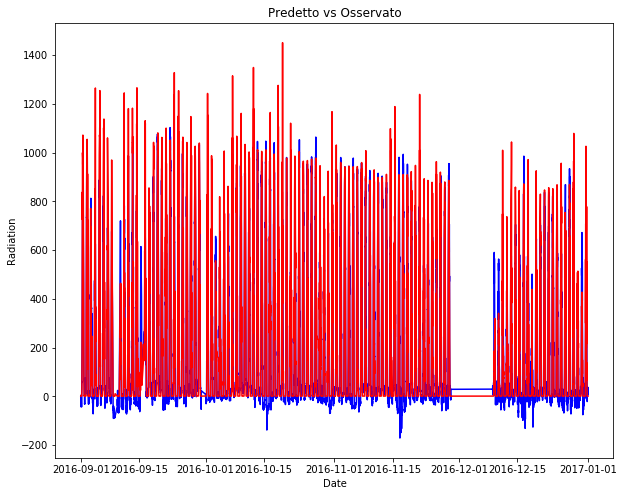

In [125]:
finalModel1.fit(X1_train,y1_train)
compareModel(X1_val.sort_index(),y1_val.sort_index(), finalModel1)

   Mean squared error: 8131.3
       Relative error: 96.06954%
R-squared coefficient: 0.92044


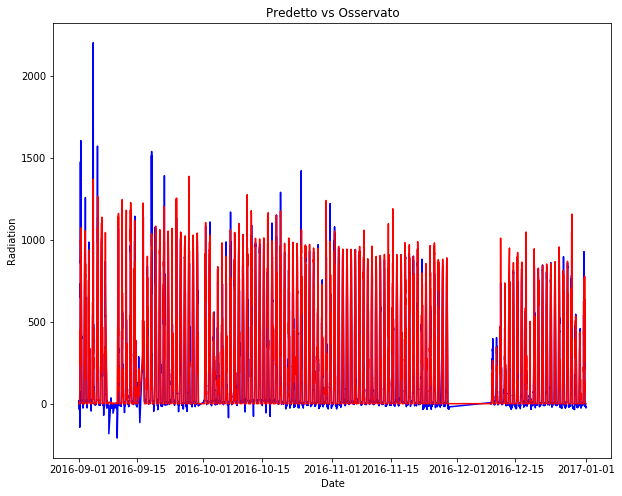

In [127]:
finalModel2.fit(X2_train,y2_train)
compareModel(X2_val.sort_index(),y2_val.sort_index(), finalModel2)